# Notebook used to look specifically at the data inside the 1000m bathymetry contour polygon (yearly, monthly, seasonally)

### relevant files:
- '/store/projects/gridded_drifter_comparisons/output/pickles/yearly_ptsin_dict.pkl': pickle file with the CMEMS track data organized in a dictionary by year that only contains the 'good' points within the 1000m bathymetry contour polygon
- '/store/bathymetry/bathy_subset.nc': bathymetry data that has be subsetted to our test area (using ETOPO1_Bed_g_gmt4.grd is slow and causes out of memory errors)
- '/store/projects/gridded_drifter_comparisons/output/plots/yearly/': storage directory for plotted output 

### polygon definition files:
- polygon definition files are stored in: '/store/projects/gridded_drifter_comparisons/polygon_definition_files/'
- 'merged_OPP-report_1000m-contour_polygon.yaml': 1000m bathymetry contour merged with OPP report
- 'bathy_polygons_all_contours.yaml': Multiple different bathymetry contour polygons for different depths
- 'OPP_drifter_report_regions_NL_LAB_shelves.yml'
  

In [1]:
import calendar
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import collections
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pylab import cm as cmlab
import numpy as np
import os
import pandas as pd
import pickle
import xarray as xr
%matplotlib inline
from IPython.display import Markdown as md
from IPython.display import HTML
import yaml
import matplotlib.colors as colors


def gen_color(cmap, n, reverse=False):
    '''see: https://github.com/binodbhttr/mycolorpy/blob/master/usage_example.ipynb'''
    c_map = matplotlib.colormaps[cmap] # select the desired cmap
    arr=np.linspace(0,1,n) #create a list with numbers from 0 to 1 with n items
    colorlist=list()
    for c in arr:
        rgba=c_map(c) #select the rgba value of the cmap at point c which is a number between 0 to 1
        clr=colors.rgb2hex(rgba) #convert to hex
        colorlist.append(str(clr)) # create a list of these colors
    if reverse==True:
        colorlist.reverse()
    return colorlist

def convert_coords_to_tuples(coords):
    coords_tuples = [tuple(l) for l in coords]
    coords_tuples = [(p[1], p[0]) for p in coords_tuples]
    return coords_tuples

def load_polygon_tuples(polyfile, area):
    f = open(polyfile, 'r')
    ym = yaml.load(f, Loader=yaml.FullLoader)
    ym_tuples = convert_coords_to_tuples(ym['polygon_coords'][area])
    return ym_tuples

def find_poly_extremes(coords):
    LatLonBoundingBox = collections.namedtuple('LatLonBoundingBox', ('minlon', 'maxlon', 'minlat', 'maxlat'))
    plons = [p[0] for p in coords]
    plats = [p[1] for p in coords]
    return LatLonBoundingBox(minlon=min(plons), maxlon=max(plons), 
                             minlat=min(plats), maxlat=max(plats))

def add_plot_components(ax, df, etopo, titlestr, show_legend=True, show_colorbar=True, tcolors=None, poly=None):
    # add bathymetry
    bathy = xr.load_dataset(etopo)
    mesh = plt.pcolormesh(bathy.x.values, bathy.y.values, bathy.z.values, cmap=cmlab.Blues_r)
    if show_colorbar:
        cbar = plt.colorbar(mesh, fraction=0.046, pad=0.04)

    # add land and coastlines
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=2)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75, zorder=4)

    # plot the drifter track points
    fnames = np.unique(df.filenames.values)
    if not tcolors:
        colorslist = gen_color('gnuplot', len(fnames), reverse=False)
        tcolors = {fname: color for fname, color in zip(fnames, colorslist)}
    for fname in fnames:
        trackdf = df.loc[df['filenames'] == fname]
        plt.scatter(trackdf.lons.values, trackdf.lats.values, s=0.3, color=tcolors[fname], label='_no_label_')

    # add the merged region polygon
    if poly:
        plt.plot(list(zip(*poly))[0], list(zip(*poly))[1], 'w-')
        plt.plot(list(zip(*poly))[0], list(zip(*poly))[1], 'g--', dashes=(6, 6), label='1000m bathymetry contour')
        bbox = find_poly_extremes(poly)
        ax.set_extent([bbox.minlon - 0.2, bbox.maxlon + 0.2, bbox.minlat - 0.2, bbox.maxlat + 0.2])
    
    plt.title(titlestr)
    if show_legend:
        handles, labels = ax.get_legend_handles_labels() 
        plt.legend(handles, labels, facecolor='white', loc='upper right')

def assign_year_params(indf, year, cmap='gnuplot', suffix=''):
    titlestr = 'CMEMS (' + str(year) + ')'
    figname = os.path.join(plotdir, ('CMEMS_' + str(year) + '_pts_inside' + [('_' + suffix) if suffix else ''][0] + '.png'))
    colorslist = gen_color(cmap, len(np.unique(indf.filenames.values)), reverse=False)
    colorsdict = {fname: color for fname, color in zip(np.unique(indf.filenames.values), colorslist)}
    return titlestr, figname, colorsdict

def plot_points_inside(df, etopo, titlestr, figname, tcolors=None, poly=None):
    fig = plt.figure(figsize=(8, 7), facecolor='white')
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
    titlestr = (titlestr + '\n' + str(len(df)) + ' records and ' + str(len(np.unique(df.filenames.values))) + ' tracks inside test area')
    add_plot_components(ax, df, etopo, titlestr, tcolors=tcolors, poly=poly)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.1, linestyle='--', zorder=100)
    gl.top_labels = False
    gl.right_labels = False
    plt.tight_layout()
    print('.. saving ' + figname)
    plt.savefig(figname, dpi=600)

def plot_points_inside_monthly(indf, etopo, titlestr, figname, tcolors=None, poly=None):
    fig = plt.figure(figsize=(16, 12), facecolor='white')
    months = np.unique(indf['times'].dt.month.values)
    for mth in range(1, 13):
        mname = calendar.month_name[mth]
        mthdf = indf.loc[indf['times'].dt.month == mth]
        ax = fig.add_subplot(3, 4, mth, projection=ccrs.PlateCarree())
        sub_titlestr = (mname + '\n' + str(len(mthdf)) + ' points and ' + str(len(np.unique(mthdf.filenames.values))) + ' tracks')
        stitlestr = sub_titlestr.replace('\n', ': ')
        add_plot_components(ax, mthdf, etopo, stitlestr, show_legend=False, show_colorbar=False, tcolors=tcolors, poly=poly)
    plt.tight_layout()
    plt.suptitle(titlestr, y=0.99)
    print('.. saving ' + figname)
    plt.savefig(figname, dpi=600)

def plot_points_inside_seasonally(indf, etopo, titlestr, figname, tcolors=None, poly=None):
    fig = plt.figure(figsize=(8, 7), facecolor='white')
    
    sdict = {
        'winter': {'lab': 'Winter (Jan-Mar)', 'tracks': indf.loc[indf['times'].dt.month.isin(range(1, 4))]}, 
        'spring': {'lab': 'Spring (Apr-Jun)', 'tracks': indf.loc[indf['times'].dt.month.isin(range(4, 7))]}, 
        'summer': {'lab': 'Summer (Jul-Sept)', 'tracks': indf.loc[indf['times'].dt.month.isin(range(7, 10))]}, 
        'autumn': {'lab': 'Autumn (Oct-Dec)', 'tracks': indf.loc[indf['times'].dt.month.isin(range(10, 13))]}
    }
    seasons = ['winter', 'spring', 'summer', 'autumn']
    
    for ind, season in enumerate(seasons):
        ax = fig.add_subplot(2, 2, ind + 1, projection=ccrs.PlateCarree())
        sdf = sdict[season]['tracks']
        sub_titlestr = (sdict[season]['lab'] + '\n' + str(len(sdf)) + ' points and ' + str(len(np.unique(sdf.filenames.values))) + ' tracks')
        add_plot_components(ax, sdf, etopo, sub_titlestr, show_legend=False, tcolors=tcolors, poly=poly)
    
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.1, linestyle='--', zorder=100)
        gl.top_labels = False
        gl.right_labels = False
        if season in ['spring', 'autumn']:
            gl.left_labels = False
        if season in ['winter', 'spring']:
            gl.bottom_labels = False
    
    plt.tight_layout()
    plt.suptitle(titlestr, y=0.99)
    print('.. saving ' + figname)
    plt.savefig(figname, dpi=600)

In [2]:
####################################################################################
# Starting directory paths and bathymetry file
####################################################################################
plotdir = '/store/projects/gridded_drifter_comparisons/output/plots/yearly'
etopo = '/store/bathymetry/bathy_subset.nc'
polydir = '/store/projects/gridded_drifter_comparisons/polygon_definition_files/'
pickledir = '/store/projects/gridded_drifter_comparisons/output/pickles/'

####################################################################################
# load the polygon that defines the perimeter of the intersection between the OPP
# combined polygon and the 1000m bathy contour polygon
####################################################################################
intersection_polygons_file = os.path.join(polydir, 'merged_OPP-report_1000m-contour_polygon.yaml')
intpoly = load_polygon_tuples(intersection_polygons_file, 'intpoly')

####################################################################################
# load the pickle file with the CMEMS track data that has been organized in a
# dictionary by year and that only contains 'good' points that within the 1000m
# bathymetry contour polygon.
####################################################################################
picklefile_yearly = os.path.join(pickledir, 'yearly_ptsin_dict.pkl')
yearly_df_dict = pd.read_pickle(picklefile_yearly)
years = list(range(2002, 2021))
years = [2020]

# per year plots

.. saving /store/projects/gridded_drifter_comparisons/output/plots/yearly/CMEMS_2020_pts_inside.png


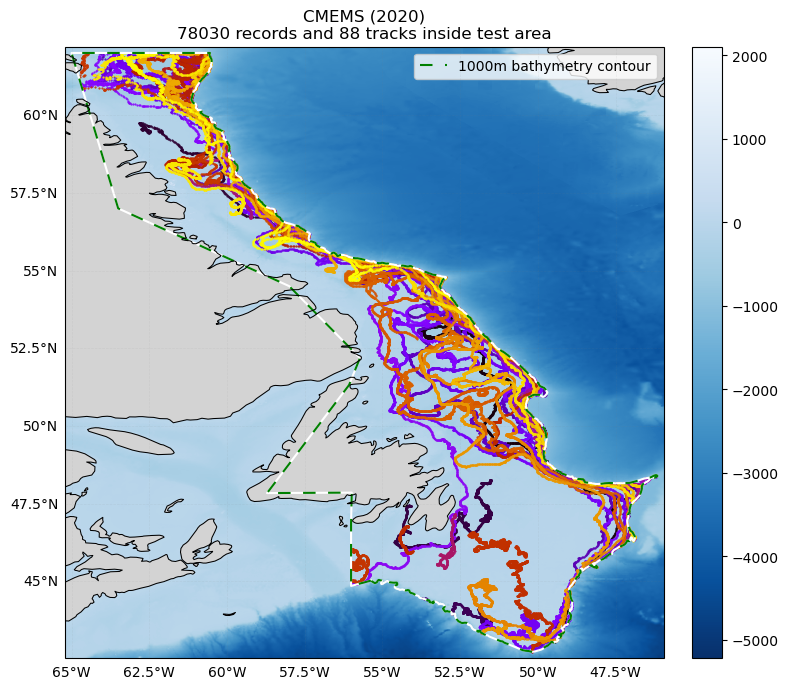

In [3]:
for year in years:
    indf = yearly_df_dict[year]
    titlestr, figname, colorsdict = assign_year_params(indf, year)
    plot_points_inside(indf, etopo, titlestr, figname, tcolors=colorsdict, poly=intpoly)

# plot the data seasonally

.. saving /store/projects/gridded_drifter_comparisons/output/plots/yearly/CMEMS_2020_pts_inside_seasonal.png


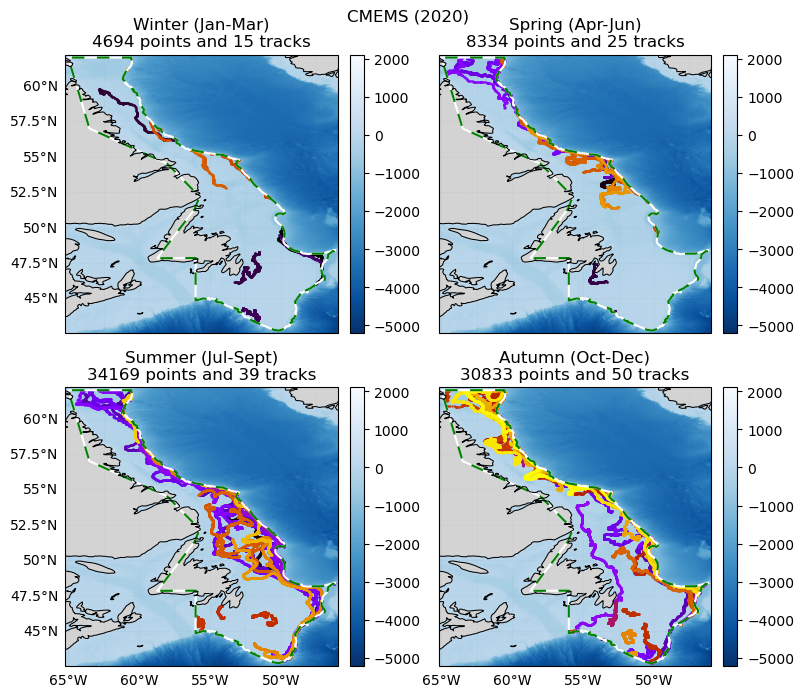

In [4]:
for year in years:
    indf = yearly_df_dict[year]
    titlestr, figname, colorsdict = assign_year_params(indf, year, suffix='seasonal')
    plot_points_inside_seasonally(indf, etopo, titlestr, figname, tcolors=colorsdict, poly=intpoly)

# monthly

.. saving /store/projects/gridded_drifter_comparisons/output/plots/yearly/CMEMS_2020_pts_inside_monthly.png


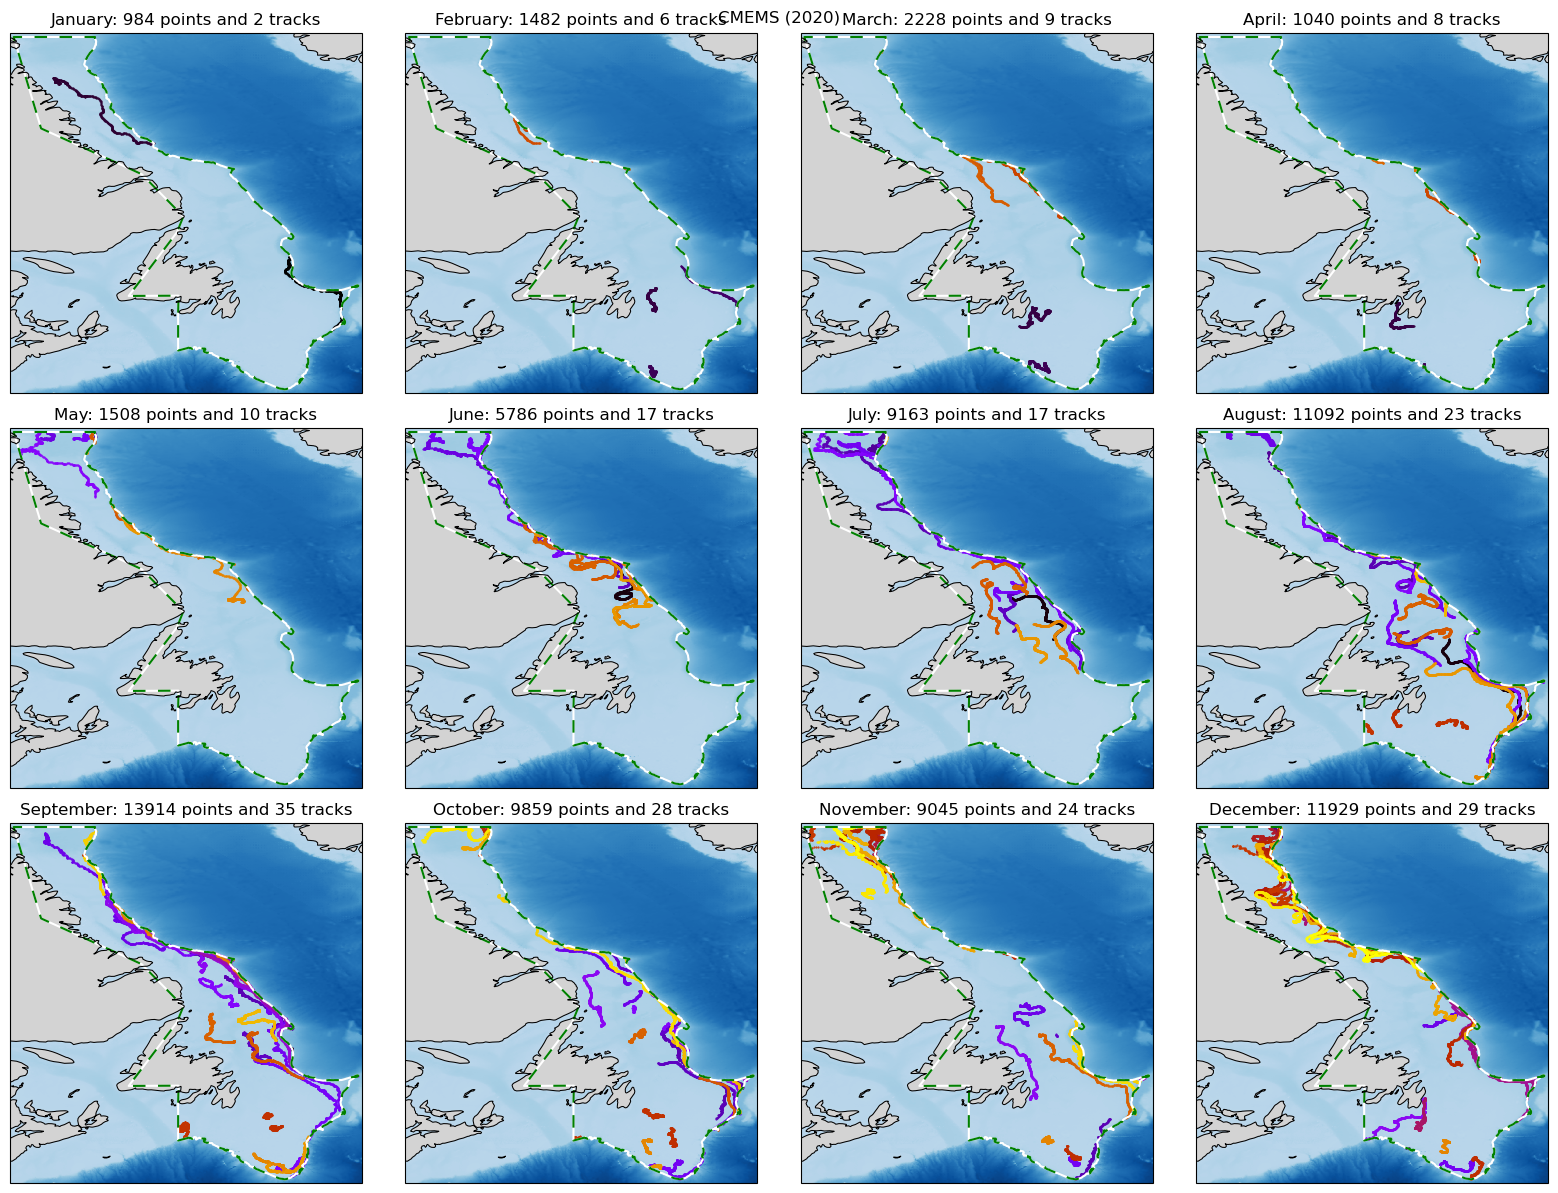

In [5]:
for year in years:
    indf = yearly_df_dict[year]
    titlestr, figname, colorsdict = assign_year_params(indf, year, suffix='monthly')
    plot_points_inside_monthly(indf, etopo, titlestr, figname, tcolors=colorsdict, poly=intpoly)

# Stats for all years



Saving /store/projects/gridded_drifter_comparisons/output/plots/yearly/points_per_year_hist.png


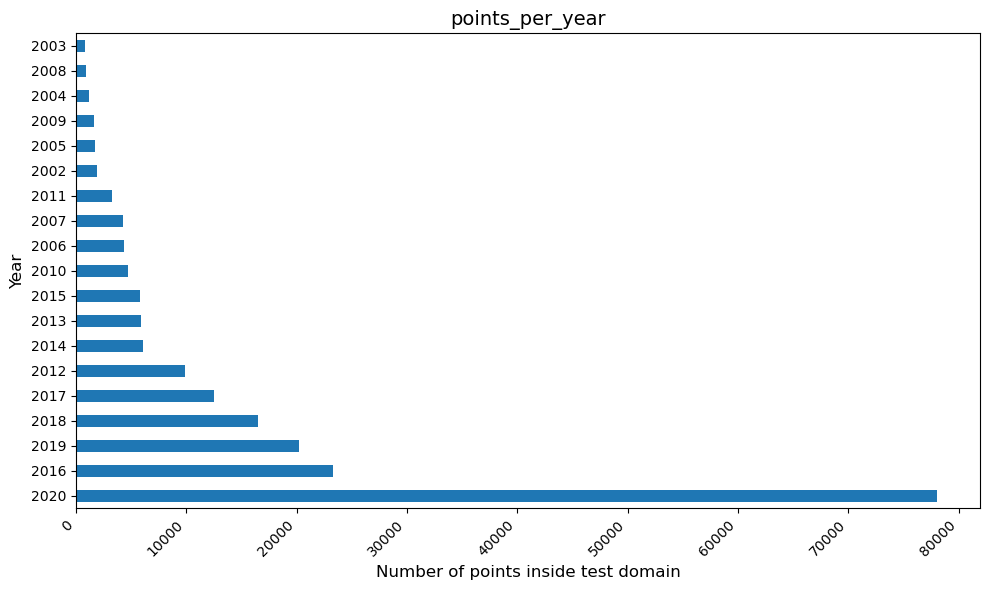

In [6]:
def determine_points_per_year(df, display_table=True):
    # to count within bins, use value_counts(bins=num_of_bins)
    ppy = pd.to_datetime(df['times']).dt.year.value_counts(normalize=False)  
    ppy_rel = pd.to_datetime(df['times']).dt.year.value_counts(normalize=True)
    countdf = pd.DataFrame()
    countdf['year'] = ppy.index.tolist()
    countdf['pts_inside'] = ppy.tolist()
    countdf['rel_freq'] = ["{:.2f}".format(relfreq) for relfreq in ppy_rel.tolist()]
    if display_table:
        display(HTML(countdf.to_html(index=False)))
    return ppy


def plot_yearly_hist(df, tstr, savedir=None):
    num_bars = len(np.unique(df.values))
    plt.figure(facecolor='white', figsize=(10, 6))
    ax = df.value_counts()[:num_bars].plot(kind='barh')
    plt.title(tstr, fontsize=14)
    plt.ylabel('Year', fontsize=12)
    plt.xlabel('Number of points inside test domain', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    if savedir is not None and os.path.isdir(savedir):
        figname = tstr + "_hist" 
        print('\n\nSaving ' + os.path.join(savedir, figname + '.png'))
        plt.savefig(os.path.join(savedir, figname + ".png"))
    plt.show()


allyrsdf = pd.DataFrame()
for year in list(range(2002, 2021)):
    indf = yearly_df_dict[year]
    allyrsdf = pd.concat([allyrsdf, indf])

ppy = determine_points_per_year(allyrsdf, display_table=True)
ppytimes = pd.to_datetime(allyrsdf['times']).dt.year
plot_yearly_hist(ppytimes, 'points_per_year', savedir=plotdir)